In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *
#from fastai.models.cifar10.resnext import resnext29_8_64
from fastai.metrics import error_rate
import torch
import tarfile
import pickle
import numpy as np
import zipfile

In [3]:
torch.cuda.is_available(),torch.cuda.current_device(),torch.cuda.get_device_name(torch.cuda.current_device())

(True, 0, 'GeForce GTX 1080')

In [4]:
Config.DEFAULT_CONFIG_PATH = 'd:/fastaiconfig.yml'
path = Config.data_path()/'alienVSpredator'
path.mkdir(parents=True, exist_ok=True)
path

WindowsPath('d:/.fastai/data/alienVSpredator')

In [5]:
with zipfile.ZipFile(path/'alien-vs-predator-images.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
path.ls()

[WindowsPath('d:/.fastai/data/alienVSpredator/alien-vs-predator-images.zip'),
 WindowsPath('d:/.fastai/data/alienVSpredator/alien_vs_predator_thumbnails'),
 WindowsPath('d:/.fastai/data/alienVSpredator/data')]

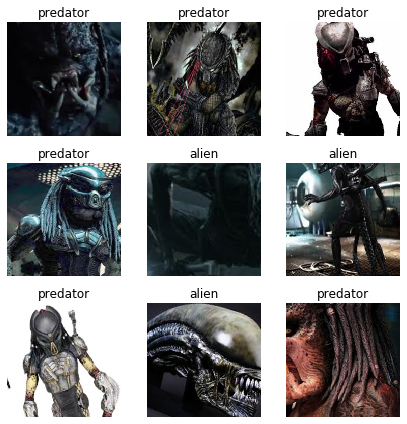

In [6]:
new_path = path/'data'
np.random.seed(1)

tfms = get_transforms(flip_vert = False, max_rotate = 20, p_affine = 1., p_lighting = 1., max_lighting = 0.2, max_zoom = 1.1, max_warp = 0.2)
img_size = 224
bs = 100
data = (ImageList.from_folder(new_path)
        .split_by_folder(valid = 'validation')
        .label_from_folder()
        .transform(tfms, size = img_size)
        .databunch(bs = bs)
        .normalize(imagenet_stats))
data.show_batch(rows = 3, figsize = (6,6))

In [7]:
data.classes, data.c

(['alien', 'predator'], 2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


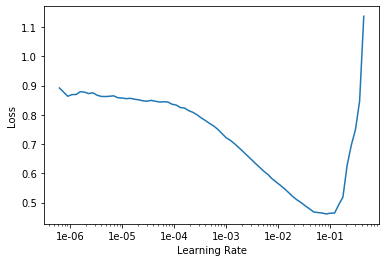

In [8]:
learn = cnn_learner(data, models.resnet34, metrics = accuracy)
gc.collect()
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(8,1e-3, wd = 0.2, div_factor = 6, pct_start = 0.8)

epoch,train_loss,valid_loss,accuracy,time
0,0.858775,0.558529,0.750000,00:40
1,0.706893,0.370428,0.865000,00:40
2,0.588244,0.259832,0.910000,00:39
3,0.503056,0.205647,0.920000,00:39
4,0.438433,0.182904,0.920000,00:39
5,0.379185,0.163889,0.925000,00:40
6,0.335440,0.148972,0.940000,00:39
7,0.304095,0.150431,0.935000,00:39


In [10]:
learn.save('stage1')

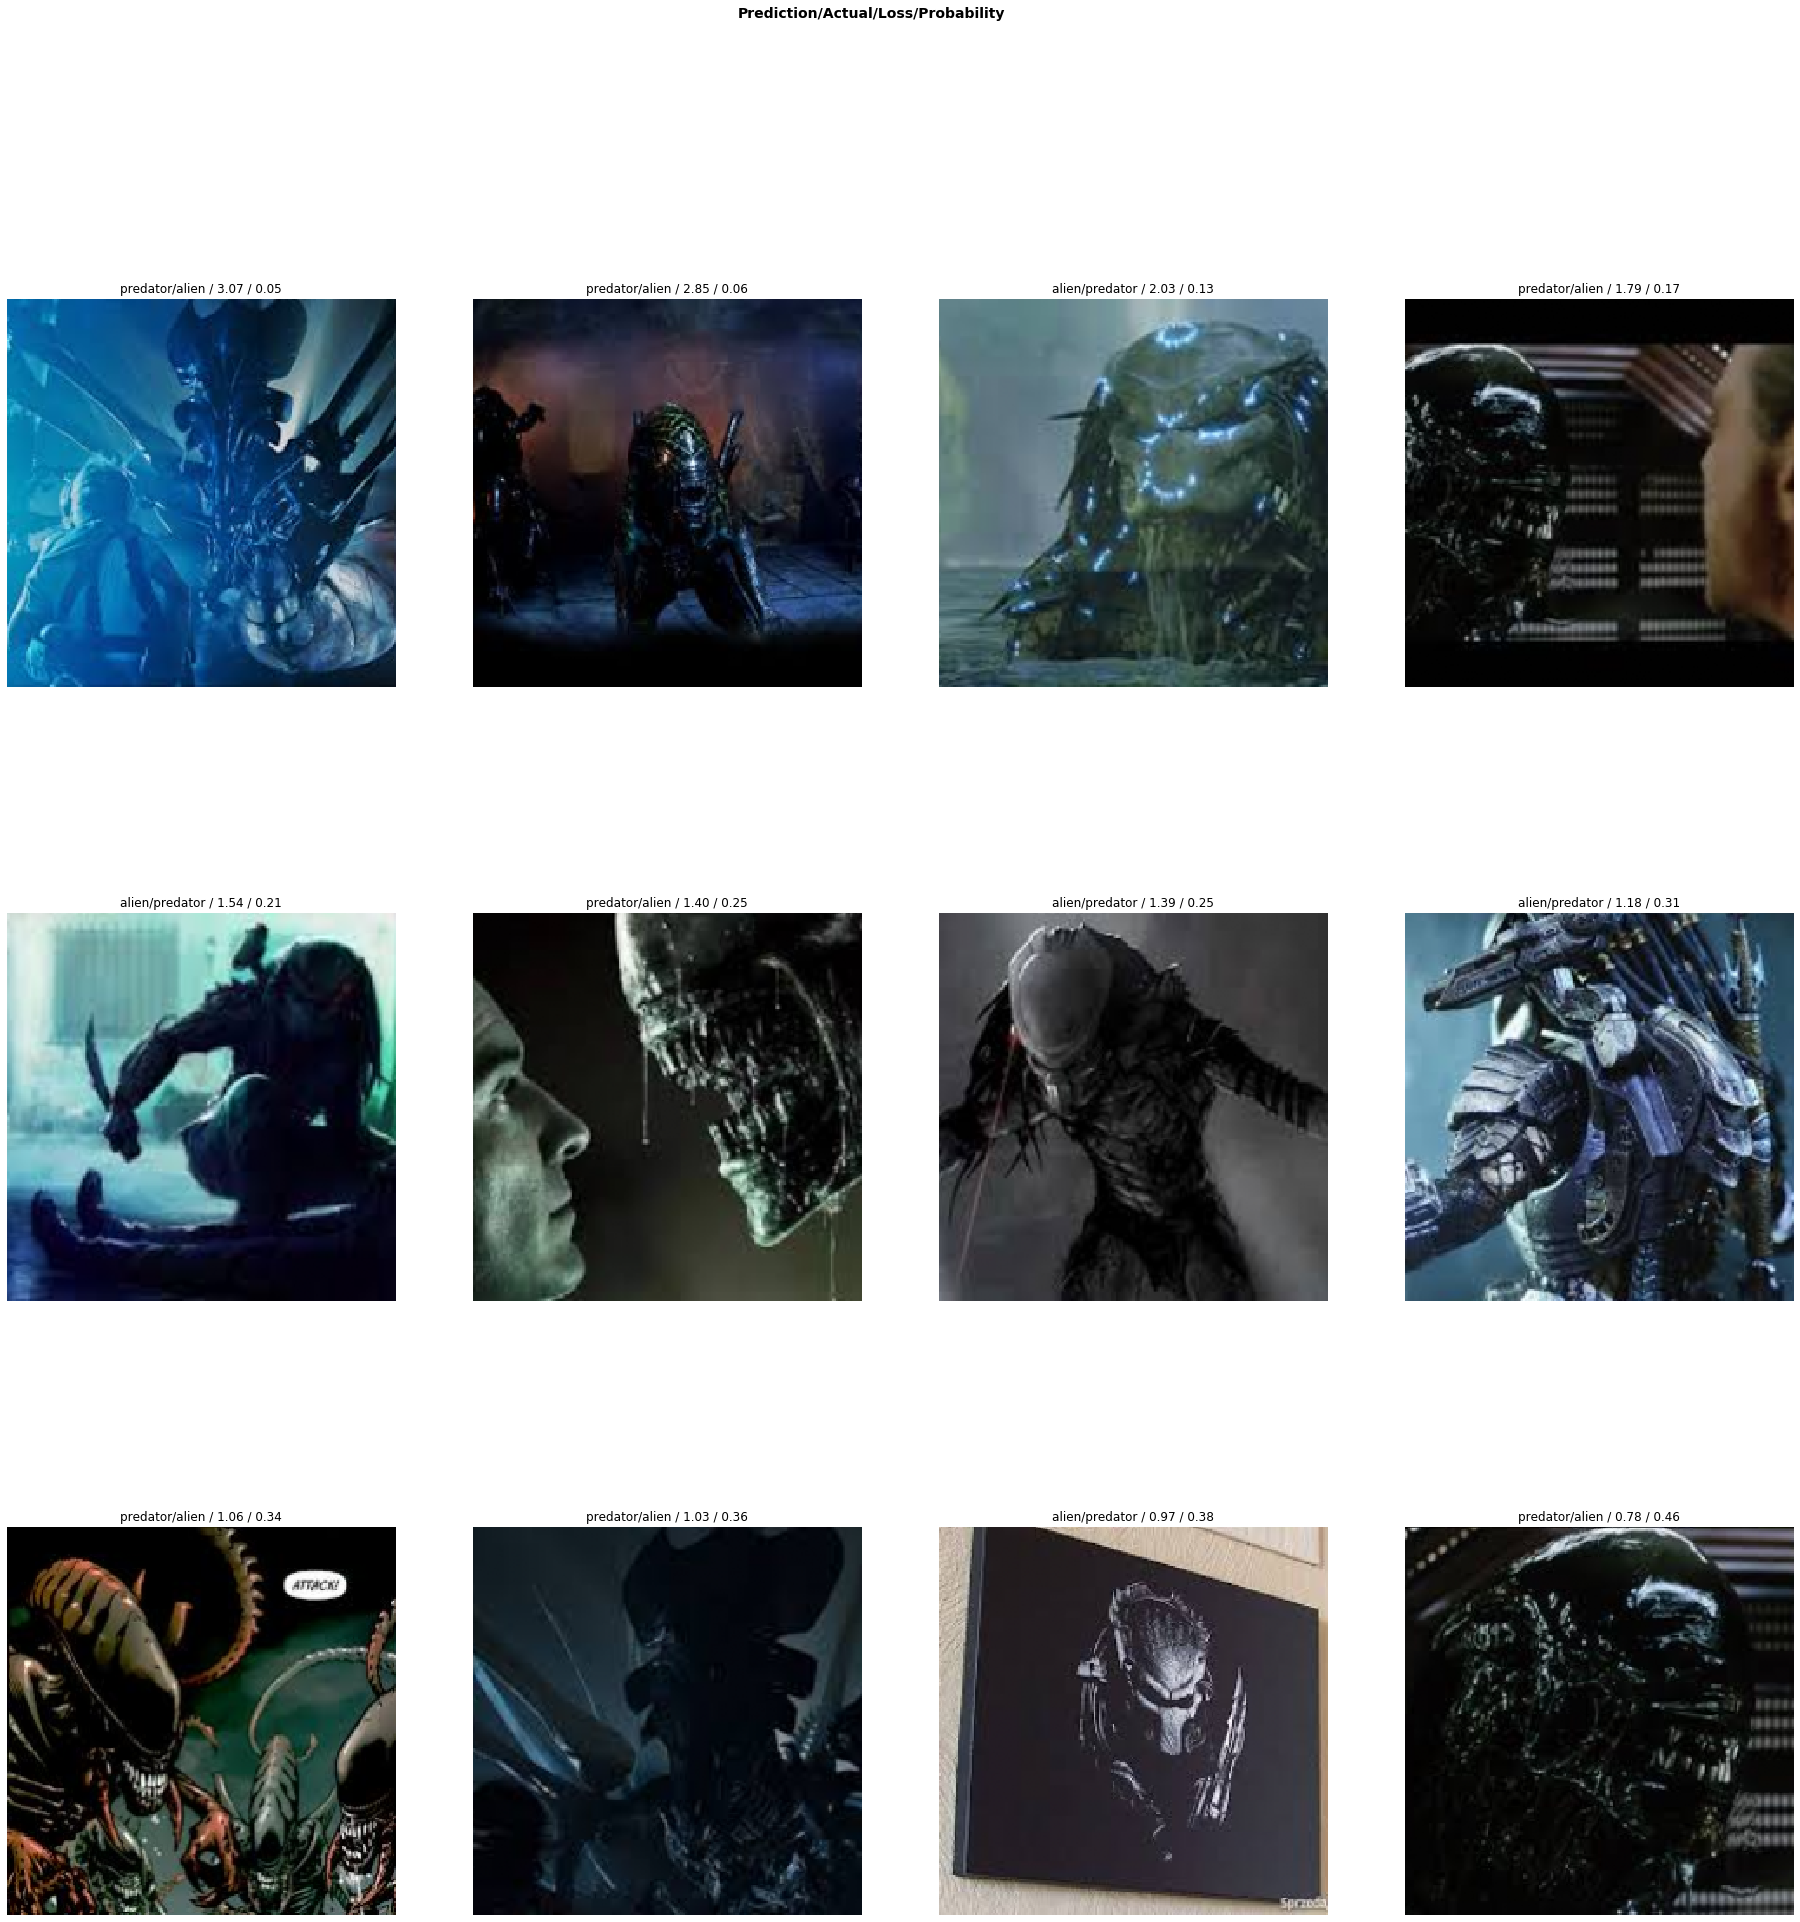

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
losses, ids = interp.top_losses()
len(data.valid_ds) == len(losses) ==len(ids)
interp.plot_top_losses(12, figsize = (32,32))

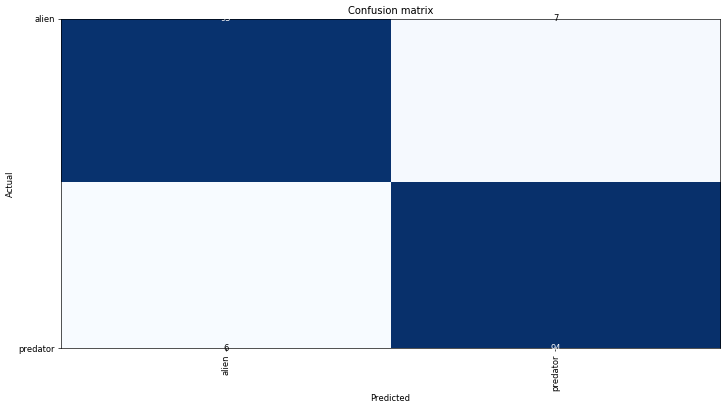

In [12]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [13]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.218141,0.746750,0.835000,00:41


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


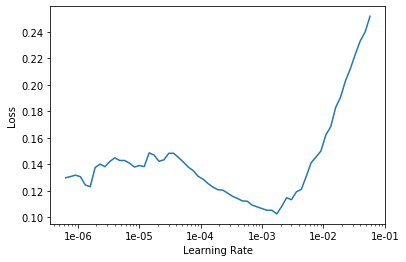

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(8,1e-4, wd = 0.2, div_factor = 5, pct_start = 0.7)

epoch,train_loss,valid_loss,accuracy,time
0,0.130717,0.252110,0.915000,00:41
1,0.147426,0.180483,0.950000,00:42
2,0.120924,0.154187,0.960000,00:42
3,0.106367,0.145180,0.950000,00:40
4,0.089349,0.171125,0.935000,00:40
5,0.078027,0.116347,0.955000,00:40
6,0.068424,0.110262,0.960000,00:40
7,0.058845,0.115116,0.960000,00:42


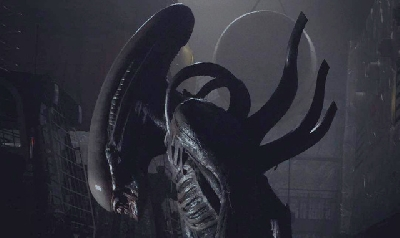

In [19]:
fn = 'D:/.fastai/data/alienVSpredator/data/test1.jpg'
x = open_image(fn);x

In [20]:
pred_class, pred_idx, outputs = learn.predict(x)
pred_class, pred_idx, outputs

(Category alien, tensor(0), tensor([9.9999e-01, 1.3509e-05]))